# DATA PREPARATION & PREPROCESSING

### IMPORTS

In [ ]:
#Import libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

# For reproducibility
np.random.seed(26)
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Activation, 
                                     Flatten, BatchNormalization,
                                     Conv2D, MaxPooling2D, 
                                     GlobalAveragePooling2D, GlobalMaxPooling2D)                                     

from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.utils import to_categorical, get_file
from tensorflow.keras.callbacks import (ModelCheckpoint, Callback, 
                                        EarlyStopping, ReduceLROnPlateau)

from keras.engine import Model
from keras import models, Input
from tensorflow.nn import softmax
from keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing

#for pretrained models
!pip install -U -q efficientnet;
!pip install -q keras-applications;
!pip install -q git+https://github.com/rcmalli/keras-vggface.git;
import efficientnet.keras as enet

from keras_vggface.vggface import VGGFace
from keras.applications import inception_v3

#for predictions
from keras.utils import get_file
from IPython.display import Image
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
#from tensorflow.image import rgb_to_grayscale

import os
import pickle
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Set working directory

In [ ]:
!ls

drive  sample_data


In [ ]:
from google.colab import drive

local = False
if local:
  working_dir = 'data/'
else:
  from google.colab import drive
  drive.mount('/content/drive')
  #_#
  working_dir = '/content/drive/MyDrive/Capstone/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Data from cropped file:
We have two dataframes that contain "cleaned" data, one is purely cleaned, while the other has images preprocessed and cropped to only zoom in on faces.

For the scope of this project, we will train our models using the preprocessed images. Our models will later be evaluated using images that have gone through preprocessing as well.

In [ ]:
cropped_df = pd.read_csv(working_dir+ 'cleaned_data/' + 'fer2013_cleaned_cropped.csv')
cropped_df

emotion  ...                                     cropped_pixels
0            0  ...  52.0 53.5 54.583332 66.666664 96.75 139.58333 ...
1            0  ...  155.0 131.375 116.645836 142.22916 163.25 168....
2            1  ...  157.0 166.28125 156.90625 165.0729 169.875 170...
3            3  ...  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4            5  ...  0.0 0.0 0.0 0.0 0.0 2.5 12.5 33.4375 53.5625 7...
...        ...  ...                                                ...
34029        0  ...  169.0 192.5625 183.5625 172.5 170.3125 175.125...
34030        5  ...  22.0 24.34375 30.083334 36.427086 40.34375 40....
34031        2  ...  178 174 172 173 181 188 191 194 196 199 200 20...
34032        0  ...  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
34033        2  ...  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...

[34034 rows x 3 columns]

In [ ]:
cropped_df['cropped_pixels'] = cropped_df.apply(lambda row: np.array(row['cropped_pixels'].split(" ")).astype('float32'), axis=1)
print(cropped_df.shape)
print(cropped_df.dtypes)

(34034, 3)
emotion            int64
pixels            object
cropped_pixels    object
dtype: object


### Train Test Split on Cropped data

In [ ]:
X = cropped_df['cropped_pixels']
y = cropped_df['emotion']
X.shape

(34034,)

In [ ]:
X = np.array(list(X))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=26,
                                                    stratify=y)
X_train

array([[ 18.      ,  16.25    ,  19.166668, ..., 157.58315 , 107.125   ,
        164.      ],
       [ 26.      ,  24.375   ,  26.75    , ...,  51.1875  ,  58.25    ,
         68.      ],
       [141.      ,  84.125   ,  52.4375  , ...,  34.875   ,  39.      ,
         39.      ],
       ...,
       [136.      , 126.      , 129.      , ..., 253.      , 253.      ,
        253.      ],
       [ 28.      ,  24.09375 ,  38.25    , ...,   5.364586,   6.65625 ,
          9.      ],
       [ 98.      ,  97.      ,  97.      , ..., 161.      , 189.      ,
        193.      ]], dtype=float32)

In [ ]:
y_train

19145    1
11763    5
18641    3
11339    4
5232     1
        ..
28012    3
14338    4
14582    4
25892    2
31343    0
Name: emotion, Length: 25525, dtype: int64

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

In [ ]:
X_train[0].shape

(48, 48, 1)

### Image Augmentation for Custom CNN Model

The ImageDataGenerator randomly augments images based on arguments passed into the function. With our original dataset, we are only limited to certain orientations and aspects of images. With the use of this ImageDataGenerator function, we can artifically introduce a wider variety of images used to train our model, such as by slight rotation, whitening and darkening, scaling, orientation adjustment as well as other techniques.

For the sake of our Custom CNN model, we will only be flipping and rescaling the images.

In [ ]:
image_gen = image.ImageDataGenerator(featurewise_center=False, #set input mean to 0 over the dataset
                                     samplewise_center=False,  #set each sample mean to 0
                                     featurewise_std_normalization=False,  #divide inputs by std of the dataset
                                     samplewise_std_normalization=False,  #divide each input by its stdev
                                     horizontal_flip=True,  #randomly flips images
                                     rescale=1./255
                                    )

image_gen.fit(X_train)
image_gen.fit(X_test)

train_flow = image_gen.flow(X_train, y_train, batch_size=32)
test_flow = image_gen.flow(X_test, y_test)

### Function for plotting Accuracy/Loss:
This function will be used to plot the performance of the model using the Accuracy and Loss functions of the model per epoch.

In [ ]:
def plot_acc_loss(history):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5));
    
    #calling train & val accuracy per epoch
  cnn_train_accuracy = history.history['accuracy']
  cnn_test_accuracy = history.history['val_accuracy']

  #generating line plot for train & val accuracy per epoch
  ax[0].plot(cnn_train_accuracy, label='Training Accuracy', color='navy')
  ax[0].plot(cnn_test_accuracy, label='Testing Accuracy', color='red')
  ax[0].legend(fontsize = 18);

  #adding title for accuracy per epoch plot
  ax[0].set_title('Training and Testing Accuracy by Epoch', fontsize = 16)
  ax[0].set_xlabel('Epoch', fontsize = 16)
  ax[0].set_ylabel('Accuracy', fontsize = 16)
  

  #calling train & val accuracy per epoch
  cnn_train_loss = history.history['loss']
  cnn_test_loss = history.history['val_loss']

  #generating line plot for train & val loss per epoch
  ax[1].plot(cnn_train_loss, label='Training Loss', color='navy')
  ax[1].plot(cnn_test_loss, label='Testing Loss', color='red')

  #adding title for loss per epoch plot
  ax[1].set_title('Training and Testing Loss by Epoch', fontsize = 16)
  ax[1].set_xlabel('Epoch', fontsize = 16)
  ax[1].set_ylabel('Categorical Crossentropy Loss', fontsize = 16)
  ax[1].legend(fontsize = 18);

# MODELLING

## CUSTOM MODELLING
This CNN was custom-made, and the topologies of pre-trained models were taken into account when custom making this model. However, it is much more simplified compared to pretrained models with only about 2 million trainable parameters.

**BatchNormalization** was used after every convolutional layer in this model. According to [this article](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/), Batch Normalization is a technique for standardizing the inputs to a layer for each mini-batch. Generally, utilizing Batch Normalization at every layer has proven to be a useful normalization technique. When running the model without the use of Batch Normalization, overfitting was more prominent than with the use of Batch Normalization.

**Max Pooling** was used with a pool size of 2x2, given the small size of our images.

Apart from this, low **dropout rates** were used at later convolutional layers, and higher dropout rates were used in the dense layers with the intention of reducing overfitting.

We ran the model over 500 epochs. **Early Stopping** was used with a patience level of 15; with the monitor being Validation Loss.

### Custom CNN Model

In [ ]:
#instantiate sequential model
cnn_model = Sequential()

#convo 1
cnn_model.add(Conv2D(filters = 32,
                     kernel_size=(3,3), #window size
                     input_shape=(48,48,1), #shape of input (image)
                     padding='same')) #pad
cnn_model.add(BatchNormalization())                     
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2))) #get max of 2x2

#convo 2
cnn_model.add(Conv2D(128, 
                     kernel_size=(3,3),
                     padding='same')) 
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

#convo 3
cnn_model.add(Conv2D(256, 
                     kernel_size=(3,3),
                     padding='valid'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

#flatten
cnn_model.add(Flatten())

#dense1
cnn_model.add(Dense(256))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.6))

#dense2
cnn_model.add(Dense(128))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.6))

#output layer              
cnn_model.add(Dense(6, activation='softmax'))

#compile
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=['accuracy'])
              
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       36992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 128)       0

In [ ]:
#adding checkpoints
checkpoint_cnn = ModelCheckpoint(filepath = working_dir+'checkpoints/cnn_{epoch:02d}.hdf5', 
                                 verbose=1, 
                                 save_best_only=False, 
                                 save_weights_only = True,
                                 monitor = 'val_accuracy',
                                 mode='max')

cnn_model_es = EarlyStopping(monitor='val_loss', 
                             min_delta=0, 
                             patience=15, 
                             mode='min',
                             restore_best_weights=True)

In [ ]:
history_cnn_model = cnn_model.fit(train_flow,
                                  batch_size=32,
                                  validation_data=test_flow,
                                  epochs=500,
                                  verbose=1,
                                  callbacks=[cnn_model_es, checkpoint_cnn])

cnn_model.save(working_dir+'cnn_model.h5')

Epoch 1/500
798/798 [==============================] - 7s 8ms/step - loss: 2.3649 - accuracy: 0.1974 - val_loss: 1.6231 - val_accuracy: 0.3468

Epoch 00001: saving model to /content/drive/MyDrive/Capstone/checkpoints/cnn_01.hdf5
Epoch 2/500
798/798 [==============================] - 6s 8ms/step - loss: 2.0000 - accuracy: 0.2673 - val_loss: 1.5362 - val_accuracy: 0.3917

Epoch 00002: saving model to /content/drive/MyDrive/Capstone/checkpoints/cnn_02.hdf5
Epoch 3/500
798/798 [==============================] - 6s 8ms/step - loss: 1.8225 - accuracy: 0.3016 - val_loss: 1.4923 - val_accuracy: 0.4056

Epoch 00003: saving model to /content/drive/MyDrive/Capstone/checkpoints/cnn_03.hdf5
Epoch 4/500
798/798 [==============================] - 6s 8ms/step - loss: 1.7093 - accuracy: 0.3257 - val_loss: 1.4663 - val_accuracy: 0.4157

Epoch 00004: saving model to /content/drive/MyDrive/Capstone/checkpoints/cnn_04.hdf5
Epoch 5/500
798/798 [==============================] - 6s 8ms/step - loss: 1.6115 - 

In [ ]:
import pickle
with open(working_dir+"train_history_cnn", 'wb') as file_pi:
        pickle.dump(history_cnn_model.history, file_pi)

history_cnn = pickle.load(open(working_dir+"train_history_cnn", "rb"))

In [ ]:
cnn_model.save(working_dir+'cnn_model.h5')

In [ ]:
cnn_model = models.load_model(working_dir+'cnn_model.h5')
cnn_model_score = cnn_model.evaluate(X_test/255, y_test, verbose=1)

266/266 [==============================] - 1s 4ms/step - loss: 1.0240 - accuracy: 0.6057


In [ ]:
cnn_model.evaluate(test_flow, verbose=1)

266/266 [==============================] - 1s 4ms/step - loss: 1.0302 - accuracy: 0.6057


[1.0301802158355713, 0.6057115793228149]

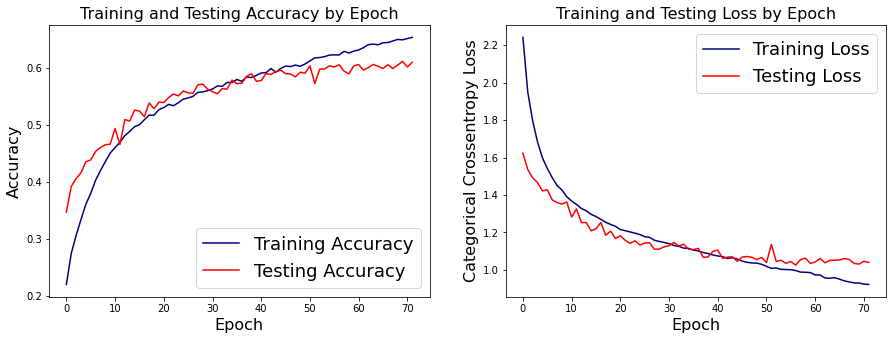

In [ ]:
plot_acc_loss(history_cnn_model)

### Evaluation
Our custom CNN Model achieved an accuracy of 60.57%, with a loss of 1.024. Our custom model seems to be slightly overfit, with train accuracies averaging about 5% higher than our test accuracy. When evaluating on augmented test images, the loss was marginally higher at 1.0302. Accuracy remained the same.

We can see from the two plots above that Accuracy started to plateau off at around the 30th epoch. Overfitting started to occur at around the 45th epoch.

Generally, our custom CNN model was quite stable despite the unsatisfactory accuracy.

##PRETRAINED MODELLING

### Preprocessing Functions

### Function to convert to input format of pretrained models

The pretrained models that we use were built to take in coloured images. We will use the below function to "fake" the RGB channels to match the input requirements, as our images are in black and white format.

In [ ]:
#training to get 3 channels
def fake_rgb(dataset):
  dataset = dataset.reshape(dataset.shape[0], 48,48)
  return np.repeat(dataset[..., np.newaxis], 3, -1)
  
#getting 3 channels
X_train_pretr = fake_rgb(X_train)
X_test_pretr = fake_rgb(X_test)

### Early stop for pretrained

**Early Stopping** for our pretrained models will also use ```validation loss``` as the monitor, but we will reduce ```patience``` to 5, as pretrained models are more computationally consuming due to the complexity of the architecture as compared to our custom-built CNN.

In [ ]:
early_stop_pretrained = EarlyStopping(monitor='val_loss',
                                      min_delta=0, 
                                      patience=5, 
                                      mode='min',
                                      restore_best_weights=True)   

In [ ]:
print(X_train[0].shape)
print(X_train_pretr[0].shape)

(48, 48, 1)
(48, 48, 3)


### Reduce Learning Rate on Plateau for pretrained

This function reduces the **learning rate** if ```val_loss``` doesn't improve after 3 epochs.

In [ ]:
pretrained_reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.2,
                                         patience=3, 
                                         min_lr=0.000001)

### Image augmentation for pretrained
Arguments passed into the ImageDataGenerator for the pretrained model are similar to that of the custom CNN model, except with ```featurewise_std_normalization=True```

In [ ]:
#do not include rescaling as it is included in pretrained!
image_gen_pretr = image.ImageDataGenerator(featurewise_center=False, #set input mean to 0 over the dataset
                                           samplewise_center=False,  #set each sample mean to 0
                                           featurewise_std_normalization=True,  #divide inputs by std of the dataset
                                           samplewise_std_normalization=False,  #divide each input by its stdev
                                           horizontal_flip=True, #randomly flips images
                                    )

image_gen_pretr.fit(X_train_pretr)
image_gen_pretr.fit(X_test_pretr)

train_flow_pretr = image_gen_pretr.flow(X_train_pretr, y_train, batch_size=32)
test_flow_pretr = image_gen_pretr.flow(X_test_pretr, y_test)

### <b>Pretrained Models</b>
In this section, we will be exploring 2 pre-trained models - VGGFace and EfficientNet.

We will carry out the modelling in 2 steps:

1) The **base model**, which has all layers frozen (with the exception of the prediction layer, that is adjusted to match the number of classes in our problem)

2) The **fine-tuned** model, where we make use of **transfer learning** where we adjust some of the hyperparameters to adapt to our problem.

Weights will not be retrained in frozen layers. In unfrozen layers of the pretrained models, weights will be retrained, so we will only be making use of the existing topology in these layers.

### VGGFACE MODEL - BASE
All layers are frozen here with the exception of the output layer.

In [ ]:
#{i: v.name for i,v in enumerate(res_model.layers)}

In [ ]:
#instantiate base model
vgg_base = VGGFace(input_shape=(224, 224, 3),
                                include_top=False, #remove default output layer
                                pooling='avg',
                                classes=6)
#freeze all layers in base model
vgg_base.trainable = False

#checking the topology of base model
vgg_base.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

In [ ]:
#update input layers
input = Input(shape=(48,48,3))
x = preprocessing.Resizing(224,224)(input)

#adding to BASE MODEL output
x = vgg_base(x)

x = Dense(6,activation='softmax')(x) #adding our own output layer

#making a new model based on existing input and new output
vgg_base = Model(input, x)

#compile
vgg_base.compile(optimizer = Adam(lr=0.001), 
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

vgg_base.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
resizing_8 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
vggface_vgg16 (Functional)   (None, 512)               14714688  
_________________________________________________________________
dense_49 (Dense)             (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
train_flow_pretr[0][0].shape

(32, 48, 48, 3)

In [ ]:
checkpoint_vgg_base = ModelCheckpoint(filepath = working_dir+'checkpoints/vgg_base_{epoch:02d}.hdf5', 
                                      verbose=1, 
                                      save_best_only=False, 
                                      save_weights_only = True,
                                      monitor = 'val_accuracy',
                                      mode='max')

In [ ]:
history_vgg_base = vgg_base.fit(train_flow_pretr,
                                validation_data = test_flow_pretr,
                                epochs = 50, 
                                verbose = 1, 
                                callbacks=[early_stop_pretrained, checkpoint_vgg_base])

Epoch 1/50
798/798 [==============================] - 65s 81ms/step - loss: 1.6284 - accuracy: 0.3331 - val_loss: 1.3996 - val_accuracy: 0.4837

Epoch 00001: saving model to /content/drive/MyDrive/Capstone/checkpoints/vgg_base_01.hdf5
Epoch 2/50
798/798 [==============================] - 65s 81ms/step - loss: 1.3555 - accuracy: 0.5099 - val_loss: 1.2870 - val_accuracy: 0.5350

Epoch 00002: saving model to /content/drive/MyDrive/Capstone/checkpoints/vgg_base_02.hdf5
Epoch 3/50
798/798 [==============================] - 65s 81ms/step - loss: 1.2531 - accuracy: 0.5462 - val_loss: 1.2333 - val_accuracy: 0.5466

Epoch 00003: saving model to /content/drive/MyDrive/Capstone/checkpoints/vgg_base_03.hdf5
Epoch 4/50
798/798 [==============================] - 65s 81ms/step - loss: 1.1937 - accuracy: 0.5623 - val_loss: 1.1982 - val_accuracy: 0.5556

Epoch 00004: saving model to /content/drive/MyDrive/Capstone/checkpoints/vgg_base_04.hdf5
Epoch 5/50
798/798 [==============================] - 65s 81

266/266 [==============================] - 16s 61ms/step - loss: 1.0767 - accuracy: 0.5910


[1.0766922235488892, 0.5910212993621826]

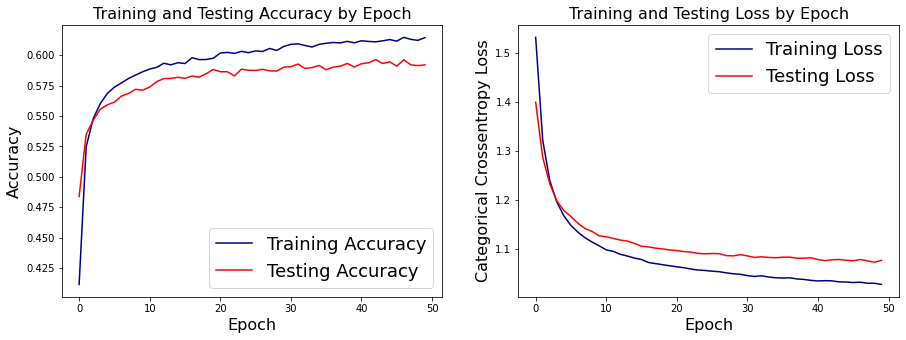

In [ ]:
vgg_base.save(working_dir + 'vgg_base.h5')

plot_acc_loss(history_vgg_base)

vgg_base.evaluate(test_flow_pretr, verbose=1)

In [ ]:
import pickle
with open(working_dir+"train_history_vgg_base", 'wb') as file_pi:
        pickle.dump(history_vgg_base.history, file_pi)

history_vgg_base = pickle.load(open(working_dir+"train_history_vgg_base", "rb"))
# history_vgg

### VGGFACE MODEL - FINETUNED

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
#instantiate base model
vgg_model = VGGFace(input_shape=(224, 224, 3),
                                include_top=False, #remove default output layer
                                pooling = 'avg',
                                classes=6)

#set all layers trainable to be true first
vgg_model.trainable = True

#freeze all BatchNormalization layers
for layer in vgg_model.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable =  False

#checking summary of topology so we can see where we want to freeze layers:
vgg_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

In [ ]:
vgg_model.layers[15].name

'conv5_1'

In [ ]:
#freeze layers up to the nth layer:
for layer in vgg_model.layers[:15]:
    layer.trainable =  False

#update input layers
input = Input(shape=(48,48,3))
x = preprocessing.Resizing(224,224)(input)

#adding to BASE MODEL output
x = vgg_model(x)
# x = vgg_model.output

# x = GlobalAveragePooling2D()(x) #base output is added after pooling

x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(6,activation='softmax')(x) #adding our own output layer

# Make a new model based on existing input and new output
vgg_model = Model(input, x)

#compile
vgg_model.compile(optimizer = Adam(lr=0.0001), 
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

vgg_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
resizing_11 (Resizing)       (None, 224, 224, 3)       0         
_________________________________________________________________
vggface_vgg16 (Functional)   (None, 512)               14714688  
_________________________________________________________________
dense_57 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_80 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_65 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 128)               328

In [ ]:
checkpoint_vgg_model = ModelCheckpoint(filepath = working_dir+'checkpoints/vgg_{epoch:02d}.hdf5', 
                             verbose=1, 
                             save_best_only=False, 
                             save_weights_only = True,
                             monitor = 'val_accuracy',
                             mode='max')  



In [ ]:
history_vgg_model = vgg_model.fit(train_flow_pretr,
                                  validation_data = test_flow_pretr,
                                  epochs = 500, 
                                  verbose = 1, 
                                  callbacks=[early_stop_pretrained,  
                                             checkpoint_vgg_model,
                                             pretrained_reduce_lr
                                       ])
vgg_model.save(working_dir + 'vgg_model.h5')

Epoch 1/500
798/798 [==============================] - 74s 91ms/step - loss: 2.8630 - accuracy: 0.2616 - val_loss: 1.3753 - val_accuracy: 0.5124

Epoch 00001: saving model to /content/drive/MyDrive/Capstone/checkpoints/vgg_01.hdf5
Epoch 2/500
798/798 [==============================] - 73s 91ms/step - loss: 1.7645 - accuracy: 0.4354 - val_loss: 1.2891 - val_accuracy: 0.5479

Epoch 00002: saving model to /content/drive/MyDrive/Capstone/checkpoints/vgg_02.hdf5
Epoch 3/500
798/798 [==============================] - 73s 91ms/step - loss: 1.5010 - accuracy: 0.4787 - val_loss: 1.1013 - val_accuracy: 0.5809

Epoch 00003: saving model to /content/drive/MyDrive/Capstone/checkpoints/vgg_03.hdf5
Epoch 4/500
798/798 [==============================] - 73s 91ms/step - loss: 1.3263 - accuracy: 0.5226 - val_loss: 1.1179 - val_accuracy: 0.5618

Epoch 00004: saving model to /content/drive/MyDrive/Capstone/checkpoints/vgg_04.hdf5
Epoch 5/500
798/798 [==============================] - 73s 92ms/step - loss:

266/266 [==============================] - 16s 62ms/step - loss: 0.9848 - accuracy: 0.6372


[0.9847609400749207, 0.6372076869010925]

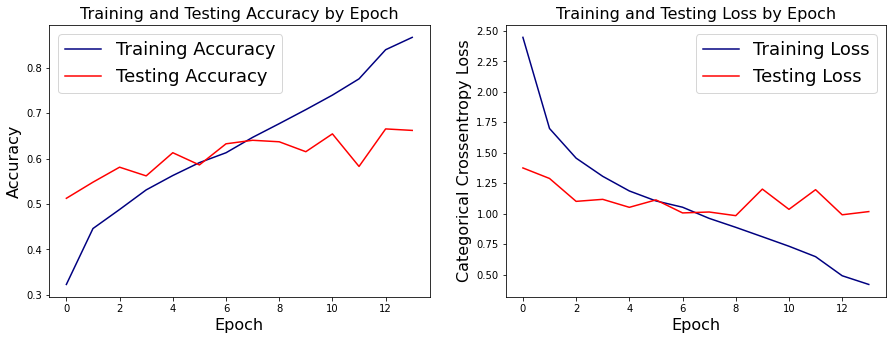

In [ ]:
plot_acc_loss(history_vgg_model)

vgg_model.evaluate(test_flow_pretr, verbose=1)

In [ ]:
with open(working_dir+"train_history_vgg_model", 'wb') as file_pi:
        pickle.dump(history_vgg_model.history, file_pi)

history_vgg_model = pickle.load(open(working_dir+"train_history_vgg_model", "rb"))

### EFFICIENTNET MODEL - BASE

In [ ]:
#instantiate base model
effnet_base = enet.EfficientNetB0(input_shape=(224,224,3),
                                include_top=False, #remove default output layer
                                weights='imagenet', 
                                pooling='avg',
                                classes=6)

#freeze all layers in base model
effnet_base.trainable = False

#checking the topology of base effnet model
effnet_base.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_33[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [ ]:
#update input layers
input = Input(shape=(48,48,3))
x = preprocessing.Resizing(224,224)(input)

#adding to base model output
x = effnet_base(x)

#adding to BASE MODEL output
x = Dense(6,activation='softmax')(x) #adding our own output layer

#making a new model based on existing input and new output
effnet_base = Model(input, x)

#compile
effnet_base.compile(optimizer = Adam(lr=0.001),                           
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

effnet_base.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
resizing_19 (Resizing)       (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 1280)              4049564   
_________________________________________________________________
dense_38 (Dense)             (None, 6)                 7686      
Total params: 4,057,250
Trainable params: 7,686
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
#{i: v.name for i,v in enumerate(effnet_model.layers)}

In [ ]:
checkpoint_effnet_base = ModelCheckpoint(filepath = working_dir+'checkpoints/effnet_base_{epoch:02d}.hdf5', 
                                         verbose=1, 
                                         save_best_only=False, 
                                         save_weights_only = True,
                                         monitor = 'val_accuracy',
                                         mode='max')

In [ ]:
history_effnet_base = effnet_base.fit(train_flow_pretr,
                                      validation_data=test_flow_pretr,
                                      epochs=1000, 
                                      verbose=1,
                                      callbacks=[early_stop_pretrained, checkpoint_effnet_base])

Epoch 1/1000
798/798 [==============================] - 45s 48ms/step - loss: 1.5634 - accuracy: 0.3718 - val_loss: 1.3799 - val_accuracy: 0.4575

Epoch 00001: saving model to /content/drive/MyDrive/Capstone/checkpoints/effnet_base_01.hdf5
Epoch 2/1000
798/798 [==============================] - 36s 46ms/step - loss: 1.3109 - accuracy: 0.5018 - val_loss: 1.2818 - val_accuracy: 0.5069

Epoch 00002: saving model to /content/drive/MyDrive/Capstone/checkpoints/effnet_base_02.hdf5
Epoch 3/1000
798/798 [==============================] - 36s 46ms/step - loss: 1.2596 - accuracy: 0.5147 - val_loss: 1.2606 - val_accuracy: 0.5197

Epoch 00003: saving model to /content/drive/MyDrive/Capstone/checkpoints/effnet_base_03.hdf5
Epoch 4/1000
798/798 [==============================] - 37s 46ms/step - loss: 1.2263 - accuracy: 0.5277 - val_loss: 1.2542 - val_accuracy: 0.5245

Epoch 00004: saving model to /content/drive/MyDrive/Capstone/checkpoints/effnet_base_04.hdf5
Epoch 5/1000
798/798 [==================

In [ ]:
history_effnet_base.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

266/266 [==============================] - 9s 34ms/step - loss: 1.2010 - accuracy: 0.5444


[1.2010178565979004, 0.5443648099899292]

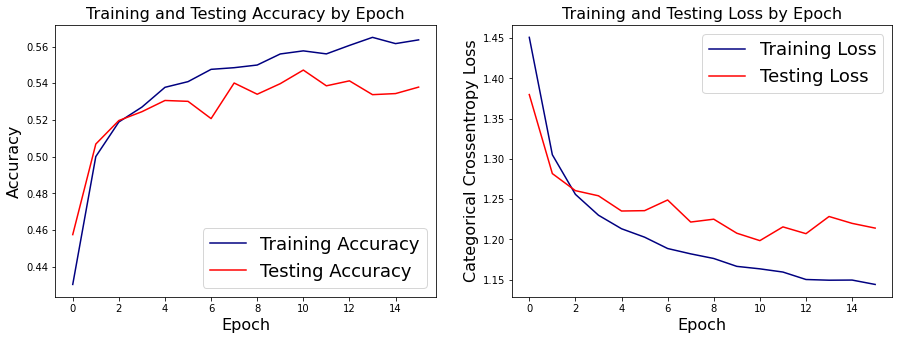

In [ ]:
effnet_base.save(working_dir + 'effnet_base.h5')

plot_acc_loss(history_effnet_base)

effnet_base.evaluate(test_flow_pretr, verbose=1)

effnet_base_score = effnet_base.evaluate(test_flow_pretr, verbose=1)
effnet_base_score

In [ ]:
# with open(working_dir+"train_history_effnet_base", 'wb') as file_pi:
#         pickle.dump(history_effnet_base.history, file_pi)

history_effnet_base = pickle.load(open(working_dir+"train_history_effnet_base", "rb"))
#history_effnet

### EFFICIENTNET MODEL - FINE TUNED

In [ ]:
#instantiate base model
effnet_model = enet.EfficientNetB0(input_shape=(224,224,3),
                                   include_top=False, #remove default output layer
                                   weights='imagenet', 
                                   classes=6)

#set all layers trainable to be true first
effnet_model.trainable = True

#checking summary of topology so we can see where we want to freeze layers:
effnet_model.summary()


Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_27[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [ ]:
effnet_model.layers[214].name
effnet_model.layers[229].name 

'top_activation'

In [ ]:
#freeze layers up to the nth layer:
for layer in effnet_model.layers[:214]:
      layer.trainable = False

#freezes batchnorm layesr for unfrozen layers      
for bn_layer in effnet_model.layers[:229]:
   if isinstance(bn_layer, BatchNormalization):
     bn_layer.trainable = False

# update input layers
input = Input(shape=(48,48,3))
x = preprocessing.Resizing(224,224)(input)

#adding to BASE MODEL output
x = effnet_model(x)

x = GlobalAveragePooling2D()(x) #base output is added after pooling

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.7)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.7)(x)

x = Dense(6,activation='softmax')(x) #adding our own output layer

#making a new model based on existing input and new output
effnet_model = Model(input, x)

#compile
effnet_model.compile(optimizer = Adam(lr=0.0001), 
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

effnet_model.summary()


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
resizing_16 (Resizing)       (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               327936    
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
activation_22 (Activation)   (None, 256)               0  

In [ ]:
checkpoint_effnet_model = ModelCheckpoint(filepath = working_dir+'checkpoints/effnet_model_{epoch:02d}.hdf5', 
                                          verbose=1, 
                                          save_best_only=False, 
                                          save_weights_only = True,
                                          monitor = 'val_accuracy',
                                          mode='max')

In [ ]:
history_effnet_model = effnet_model.fit(train_flow_pretr,
                                        validation_data=test_flow_pretr,
                                        epochs=1000, 
                                        verbose=1,
                                        callbacks=[early_stop_pretrained,
                                                   checkpoint_effnet,
                                                   pretrained_reduce_lr
                                                   ])

Epoch 1/1000
798/798 [==============================] - 49s 53ms/step - loss: 2.3758 - accuracy: 0.2170 - val_loss: 1.4148 - val_accuracy: 0.4456

Epoch 00001: saving model to /content/drive/MyDrive/Capstone/checkpoints/effnet_model_01.hdf5
Epoch 2/1000
798/798 [==============================] - 41s 51ms/step - loss: 1.8568 - accuracy: 0.3356 - val_loss: 1.2844 - val_accuracy: 0.4991

Epoch 00002: saving model to /content/drive/MyDrive/Capstone/checkpoints/effnet_model_02.hdf5
Epoch 3/1000
798/798 [==============================] - 41s 51ms/step - loss: 1.5631 - accuracy: 0.4182 - val_loss: 1.2358 - val_accuracy: 0.5276

Epoch 00003: saving model to /content/drive/MyDrive/Capstone/checkpoints/effnet_model_03.hdf5
Epoch 4/1000
798/798 [==============================] - 41s 51ms/step - loss: 1.4439 - accuracy: 0.4436 - val_loss: 1.1990 - val_accuracy: 0.5433

Epoch 00004: saving model to /content/drive/MyDrive/Capstone/checkpoints/effnet_model_04.hdf5
Epoch 5/1000
798/798 [==============

266/266 [==============================] - 9s 35ms/step - loss: 0.9775 - accuracy: 0.6475


[0.9774616956710815, 0.6475496292114258]

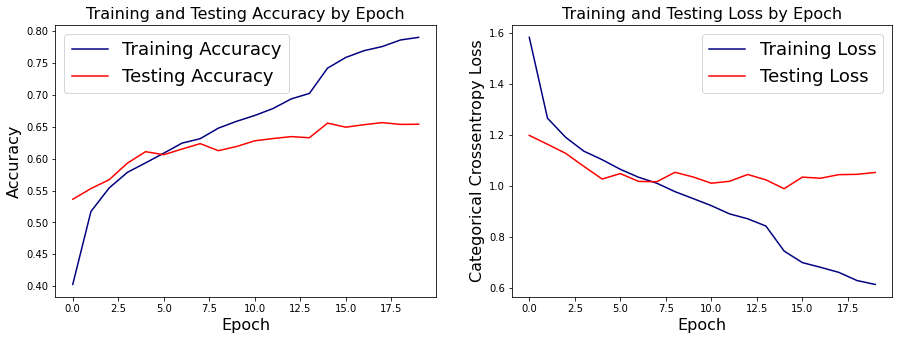

In [ ]:
effnet_model.save(working_dir + 'effnet_model.h5')

plot_acc_loss(history_effnet_model)

effnet_model.evaluate(test_flow_pretr, verbose=1)

effnet_model_score = effnet_model.evaluate(test_flow_pretr, verbose=1)
effnet_model_score

In [ ]:
with open(working_dir+"train_history_effnet_model", 'wb') as file_pi:
        pickle.dump(history_effnet_model.history, file_pi)

history_effnet_base = pickle.load(open(working_dir+"train_history_effnet_base", "rb"))
#history_effnet

# PREDICTIONS 

## LABELLED DATA

In general for our predictions section, we will be focusing on our two best performing models - our custom CNN as well as the fine-tuned EfficientNetB0.

However for the sake of visualization purposes, we will run predictions for labelled images on all models just to get a rough gauge of how well all models perform on the test set.

### Loading all models

In [ ]:
cnn_model = models.load_model(working_dir+'cnn_model.h5')
vgg_base = models.load_model(working_dir + 'vgg_base.h5')
vgg_model = models.load_model(working_dir + 'vgg_model.h5')
effnet_base = models.load_model(working_dir + 'effnet_base.h5')
effnet_model = models.load_model(working_dir + 'effnet_model.h5')

cnn_model_score = cnn_model.evaluate(test_flow, verbose=1)
vgg_base_score = vgg_base.evaluate(test_flow_pretr, verbose=1)
vgg_model_score = vgg_model.evaluate(test_flow_pretr, verbose=1)
effnet_base_score = effnet_base.evaluate(test_flow_pretr, verbose=1)
effnet_model_score = effnet_model.evaluate(test_flow_pretr, verbose=1)

266/266 [==============================] - 10s 34ms/step - loss: 0.9776 - accuracy: 0.6508


In [ ]:
#divide inputs by standard deviation of the dataset (featurewise)
X_pred = X_test_pretr - X_test_pretr.mean(0)
X_pred = X_pred/X_pred.std(0)

### Predictions Using Custom CNN

In [ ]:
emotions = ['angry','fear','happy','sad','suprise','neutral']

In [ ]:
model_predictions = cnn_model.predict(X_test/255)

#translate predictions into emotions
y_pred = np.array([np.argmax(z) for z in model_predictions])
y_actual = np.array([np.argmax(z) for z in y_test])

#creating dataframe of predicted values
data = {'pred': y_pred, 'actual':y_actual}
pred_df_cnn = pd.DataFrame(data)
pred_df_cnn['is_same'] = pred_df_cnn['pred'] == pred_df_cnn['actual']

#counting correct and incorrect predictions
valcount_cnn = pred_df_cnn['is_same'].value_counts()

print(valcount_cnn)

True     5154
False    3355
Name: is_same, dtype: int64


### Predictions using VGG BASE & VGG FINE TUNED

In [ ]:
model_predictions = vgg_base.predict(X_pred)

#Translate predictions into emotion
y_pred = np.array([np.argmax(z) for z in model_predictions])
y_actual = np.array([np.argmax(z) for z in y_test])

# Create dataframe of predicted values
data = {'pred': y_pred, 'actual':y_actual}
pred_df_vgg_b = pd.DataFrame(data)

pred_df_vgg_b['is_same'] = pred_df_vgg_b['pred'] == pred_df_vgg_b['actual']

#counting correct and incorrect predictions
valcount_vgg_b = pred_df_vgg_b['is_same'].value_counts()

print(valcount_vgg_b)

True     4677
False    3832
Name: is_same, dtype: int64


In [ ]:
model_predictions = vgg_model.predict(X_pred)

#Translate predictions into emotion
y_pred = np.array([np.argmax(z) for z in model_predictions])
y_actual = np.array([np.argmax(z) for z in y_test])

# Create dataframe of predicted values
data = {'pred': y_pred, 'actual':y_actual}
pred_df_vgg = pd.DataFrame(data)
pred_df_vgg['is_same'] = pred_df_vgg['pred'] == pred_df_vgg['actual']

#counting correct and incorrect predictions
valcount_vgg = pred_df_vgg['is_same'].value_counts()

print(valcount_vgg)

True     5012
False    3497
Name: is_same, dtype: int64


### Predictions using EFFNET BASE & EFFNET FINE TUNED

In [ ]:
model_predictions = effnet_base.predict(X_pred)

#Translate predictions into emotion
y_pred = np.array([np.argmax(z) for z in model_predictions])
y_actual = np.array([np.argmax(z) for z in y_test])

# Create dataframe of predicted values
data = {'pred': y_pred, 'actual':y_actual}
pred_df_effnet_b = pd.DataFrame(data)
pred_df_effnet_b['is_same'] = pred_df_effnet_b['pred'] == pred_df_effnet_b['actual']

pred_df_effnet_b['is_same'].value_counts()

#counting correct and incorrect predictions
valcount_effnet_b = pred_df_effnet_b['is_same'].value_counts()

print(valcount_effnet_b)
print(f"Prediction Accuracy for EfficientNetB0 base: {valcount_effnet_b[True]/valcount_effnet_b.sum()} ")

True     4477
False    4032
Name: is_same, dtype: int64
Prediction Accuracy for EfficientNetB0 base: 0.5261487836408508 


In [ ]:
model_predictions = effnet_model.predict(X_pred)

#Translate predictions into emotion
y_pred = np.array([np.argmax(z) for z in model_predictions])
y_actual = np.array([np.argmax(z) for z in y_test])

# Create dataframe of predicted values
data = {'pred': y_pred, 'actual':y_actual}
pred_df_effnet = pd.DataFrame(data)
pred_df_effnet['is_same'] = pred_df_effnet['pred'] == pred_df_effnet['actual']

#counting correct and incorrect predictions
valcount_effnet = pred_df_effnet['is_same'].value_counts()

print(valcount_effnet)
print(f"Prediction Accuracy for EfficientNetB0 model: {valcount_effnet[True]/valcount_effnet.sum()} ")

True     5292
False    3217
Name: is_same, dtype: int64
Prediction Accuracy for EfficientNetB0 model: 0.6219297214713833 


### Summary of predictions on labelled data

In [ ]:
print("CNN")
print(valcount_cnn)
print(f"Prediction Accuracy for CNN: {valcount_cnn[True]/valcount_cnn.sum()}", "\n")
print("VGG BASE")
print(valcount_vgg_b)
print(f"Prediction Accuracy for VGG base: {valcount_vgg_b[True]/valcount_vgg_b.sum()}", "\n")
print("VGG MODEL")
print(valcount_vgg)
print(f"Prediction Accuracy for VGG tuned: {valcount_vgg[True]/valcount_vgg.sum()}","\n")
print("EFFICIENT NET BASE")
print(valcount_effnet_b)
print(f"Prediction Accuracy for EfficientNetB0 base: {valcount_effnet_b[True]/valcount_effnet_b.sum()}", "\n")
print("EFFICIENT NET MODEL")
print(valcount_effnet)
print(f"Prediction Accuracy for EfficientNetB0 tuned: {valcount_effnet[True]/valcount_effnet.sum()}")

CNN
True     5154
False    3355
Name: is_same, dtype: int64
Prediction Accuracy for CNN: 0.6057115994829004 

VGG BASE
True     4677
False    3832
Name: is_same, dtype: int64
Prediction Accuracy for VGG base: 0.5496533082618404 

VGG MODEL
True     5012
False    3497
Name: is_same, dtype: int64
Prediction Accuracy for VGG tuned: 0.5890233870019979 

EFFICIENT NET BASE
True     4477
False    4032
Name: is_same, dtype: int64
Prediction Accuracy for EfficientNetB0 base: 0.5261487836408508 

EFFICIENT NET MODEL
True     5292
False    3217
Name: is_same, dtype: int64
Prediction Accuracy for EfficientNetB0 tuned: 0.6219297214713833


As we can see above, the accuracies for our test data are best when using our Custom CNN and our EfficientNetB0 tuned models, with 60.57% & 62.19% accuracy respectively. We will be focusing on these two models moving forward, as well as in our analysis.

## UNSEEN DATA
In attempt to test our models on unseen data, we created a dataframe consisting of manually gathered and labelled image URLs and labels.

However, since this does not come from the same dataset as our train and test images, the images are not in the same size and format and thus are required to go through some preprocessing before carrying out the predictions.

The processing comes in two steps - A function to crop faces, and a processing function that takes the image URL and returns a format that will be used in the crop function.

We will be focusing on two of our best performing models - the custom CNN and the fine-tuned EffNetB0 models.

### Reading in CSV

In [ ]:
test = pd.read_csv(working_dir + 'images_download.csv', verbose=0)

### Face Cropping function

In [ ]:
def crop_face(pixels, missed_images=[], name=0):
    #cv2 takes in an int and a flat image (no channels)
    gray = pixels.reshape(pixels.shape[0],pixels.shape[1]).astype('uint8')
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt.xml")
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.01,
                                         minNeighbors=3,
                                         minSize=(24, 24)
                                        )
    #return original if no faces found
    if (len(faces) == 0):
        missed_images.append(name)
        return pixels

    max_w=0
    #looping through all detected faces
    for (x, y, w, h) in faces:
      #only selecting the largest face
      if (w > max_w):
        max_w = w
        face = (x,y,w,h)

    (x,y,w,h) = face
    #focusing on face
    gray = gray[y:y+h,x:x+w]
    #adding back channel
    gray = gray.reshape((gray.shape[0], gray.shape[1], 1))
    #reshape back to 48x48
    gray = image.smart_resize(gray, (48,48))
    return gray.astype('float32')

### Image processing

In [ ]:
def process_image(url):
  head, tail = os.path.split(url)
  img_path = utils.get_file(tail, origin=url);
  img = image.load_img(img_path, color_mode='grayscale')
  x = image.img_to_array(img)
  return crop_face(x)

Now that we have the above two functions, we can apply the process_image function to our dataset containing image urls.

In [ ]:
#applying process_image function to url dataset
test['processed'] = test.apply(lambda row: process_image(row['url']), axis=1)
X_new = np.array(list(test['processed']))
y_new = test['label']

### Predictions using CUSTOM CNN MODEL

In [ ]:
#predictions on unseen data using custom cnn model
X_new = np.array(list(test['processed']))
y_new = test['label']

X_new_pred = X_new/255

cnn_predictions = cnn_model.predict(X_new_pred)

#translating one hot encoded preds into emotion classes
y_pred_cnn = np.array([np.argmax(z) for z in cnn_predictions])

#creating a dataframe for predicted values
data = {'pred': y_pred_cnn, 'actual':y_new} 
pred_df_cnn_new = pd.DataFrame(data)
pred_df_cnn_new['is_same'] = pred_df_cnn_new['pred'] == pred_df_cnn_new['actual']

#counting correctly/incorrectly predicted images
val_count_cnn_new = pred_df_cnn_new['is_same'].value_counts()
print(val_count_cnn_new)
print(f"Prediction Accuracy for Custom CNN: {val_count_cnn_new[True]/val_count_cnn_new.sum()}")

True     31
False    21
Name: is_same, dtype: int64
Prediction Accuracy for Custom CNN: 0.5961538461538461


### Predictions using Tuned EfficientNet Model

In [ ]:
#predictions on unseen data using tuned effnet model
X_new = np.array(list(test['processed']))
y_new = test['label']

X_new_pred = X_new - X_new.mean(0)
X_new_pred = X_new_pred/X_new_pred.std(0)

#applying fake_rgb function to X_new_pred to match input requirements
X_new_pred_effnet = fake_rgb(X_new_pred)
model_predictions_effnet = effnet_model.predict(X_new_pred_effnet)

#translating one hot encoded preds into emotion classes
y_pred_effnet = np.array([np.argmax(z) for z in model_predictions_effnet])

#creating a dataframe for predicted values
data = {'pred': y_pred_effnet, 'actual':y_new} 
pred_df_effnet_new = pd.DataFrame(data)
pred_df_effnet_new['is_same'] = pred_df_effnet_new['pred'] == pred_df_effnet_new['actual']

#counting correctly/incorrectly predicted images
val_count_effnet = pred_df_effnet_new['is_same'].value_counts()
print(val_count_effnet)
print(f"Prediction Accuracy for efficient net: {val_count_effnet[True]/val_count_effnet.sum()}")

True     31
False    21
Name: is_same, dtype: int64
Prediction Accuracy for efficient net: 0.5961538461538461


In [ ]:
pred_df_effnet.head(5)

pred  actual  is_same
0     3       0    False
1     0       0     True
2     0       0     True
3     0       0     True
4     3       0    False

In [ ]:
pred_df_cnn.head(5)

pred  actual  is_same
0     5       0    False
1     0       0     True
2     0       0     True
3     0       0     True
4     0       0     True

In [ ]:
print("CNN")
print(val_count_cnn)
print(f"Prediction Accuracy for Custom CNN: {val_count_cnn[True]/val_count_cnn.sum()}","\n")
print("Efficient Net")
print(val_count_effnet)
print(f"Prediction Accuracy for efficient net: {val_count_effnet[True]/val_count_effnet.sum()}")

CNN
True     31
False    21
Name: is_same, dtype: int64
Prediction Accuracy for Custom CNN: 0.5961538461538461 

Efficient Net
True     31
False    21
Name: is_same, dtype: int64
Prediction Accuracy for efficient net: 0.5961538461538461


In terms of unseen data, both our custom CNN and the EfficientNetB0 have the same number of True and False predictions. We checked both dataframes to make sure that both models weren't predicting the exact same images incorrectly. Performance wise, both performed slightly worse than on our test set.


#PREDICTION & MISCLASSIFICATION ANALYSIS

Misclassification of Labelled Images:

In this section, we'll be using our EfficientNetB0 model to carry out the analysis on misclassified images.






The below plots will help us get an overall picture of which classes have been misclassified the most.

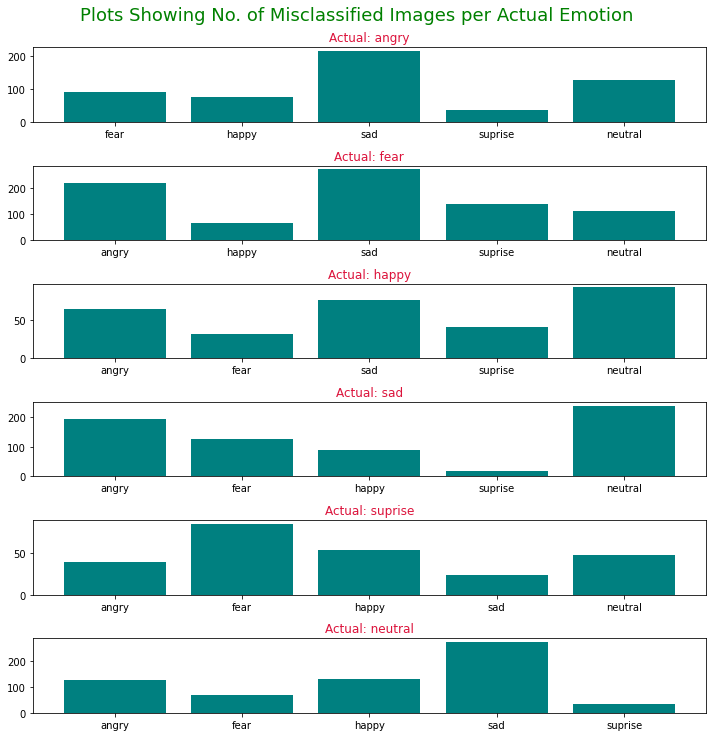

In [ ]:
import random
pred_df = pred_df_effnet
fig, ax = plt.subplots(nrows = 6, figsize = (10,10))

for current_emo in range(0,6):
  misclassed_y=[]
  for misclass_emo in range(0,6):
    if misclass_emo != current_emo:
      misclassed_y.append(len(pred_df[(pred_df['actual']==current_emo) & (pred_df['pred']==misclass_emo)]))

  x_axis = [emo for emo in emotions if emo != emotions[current_emo]]
  ax[current_emo].bar(x_axis, misclassed_y, color='teal');
  

  ax[current_emo].set_title(f"Actual: {emotions[current_emo]}", color='crimson')

  fig.tight_layout()

fig.suptitle(f"Plots Showing No. of Misclassified Images per Actual Emotion", 
             fontsize=18, 
             y=1.02,
             color='green');

We can see from the above plots that Angry, Fear, Sad and Neutral have y-axis labels going up to 200. 

To get a more quantitative perspective, we can look at the misclassified value counts below:

In [ ]:
misclassified_count = pd.DataFrame(
    pred_df_effnet[pred_df_effnet['actual'] != pred_df_effnet['pred']].groupby('actual')['is_same'].value_counts())

misclassified_count.columns = ['misclassified_count']
misclassified_count.sort_values(by='misclassified_count', ascending=False)

misclassified_count
actual is_same                     
1      False                    804
3      False                    668
5      False                    643
0      False                    546
2      False                    304
4      False                    252

The top 3 misclassified emotions were Fear, Sad and Neutral, with Angry being a close 4th. We will plot a random list of misclassified images from each actual class to see why.

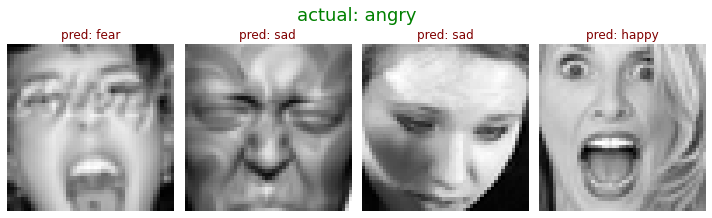

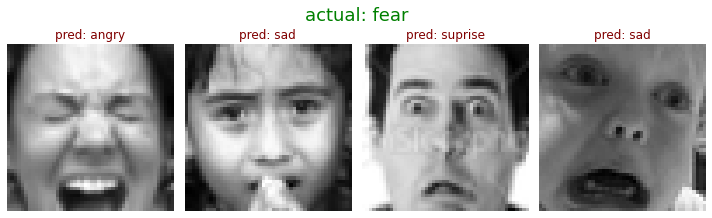

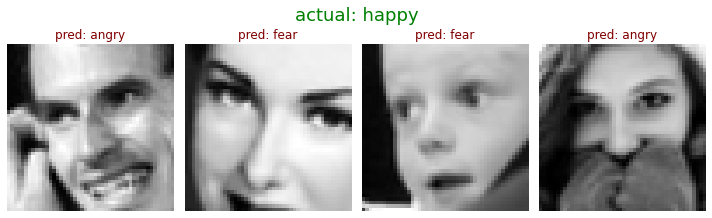

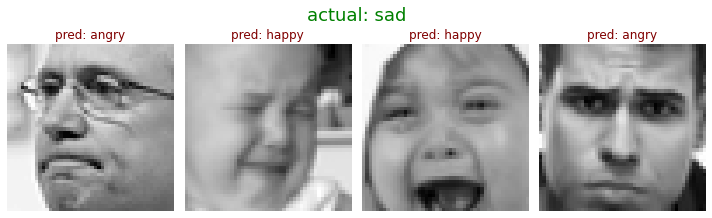

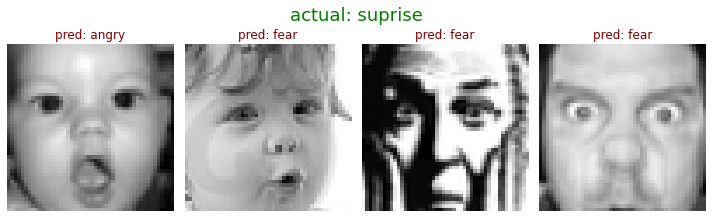

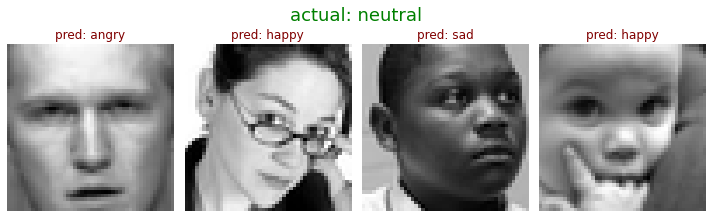

In [ ]:
import random
pred_df = pred_df_effnet

#loop through all images
for current_emo in range(0,6):
    
    #4 pics per row
    fig, ax = plt.subplots(ncols = 4, figsize = (10,4))

    #creating a df of how often an emotion was incorrectly predicted
    emp_pred_count = pd.DataFrame(pred_df[pred_df['actual']==current_emo]['pred'].value_counts())
    emp_pred_count['emo'] = emp_pred_count.index
    
    # Get top ones where it was wrong (other than itself)
    most_pred = list(emp_pred_count[emp_pred_count['emo'] != current_emo]['emo'])[0]
    
    # filter for images of those we predicted incorrectly
    emos_most_predicted = list(pred_df[(pred_df['actual']==current_emo) & (pred_df['pred']!=current_emo)].index)
    
    # Pick 4 of the rows from the prediction dataframe
    for j,row_index in enumerate(random.sample(emos_most_predicted, 4)):
      img = X_test[row_index].reshape(48,48)
      ax[j].imshow(img, cmap = plt.get_cmap('gray'))
      ax[j].axis('off')
      actual = pred_df.loc[row_index]['actual']
      pred = pred_df.loc[row_index]['pred']
      ax[j].set_title(f"pred: {emotions[pred]}", color='maroon')

    fig.suptitle(f"actual: {emotions[current_emo]}", fontsize=18, y=0.92, color='green')
    fig.tight_layout()

Based on our the above images and barplots here are the key takeaways.
- Fear was mostly misclassified as Sad and Angry
- Sad was mostly misclassified as Angry and Neutral
- Neutral was mostly misclassified as Sad and Angry
- Anger was mostly misclassified as Sad and Neutral

We also see this in the confusion plot below that helps us to visualize the Actual vs Predicted emotions. Happy and Surprise had the highest values (deepest colours), and this tells us that the two classes were the best predicted.

In further analysis, the four most misclassified images seem to be misclassified as each other. If we look at the photos, the misclassification seems to be somewhat reasonable as some of these emotions are difficult to tell apart even to human perception.

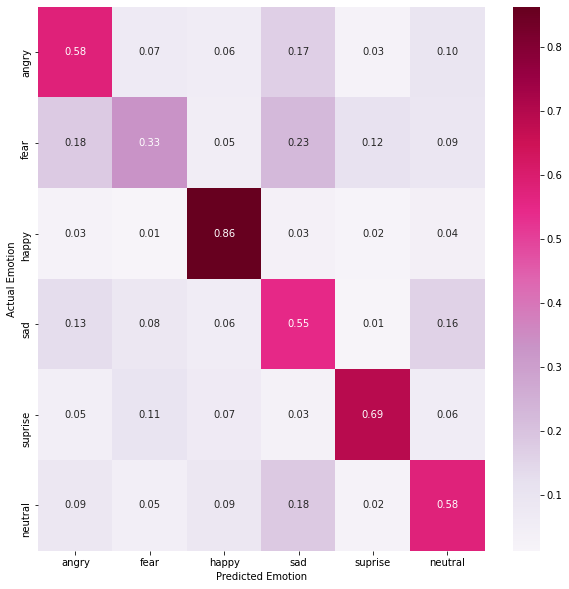

In [ ]:
def plot_confusion_matrix(cm, classes):
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cm_normalised, 
                     annot=True, 
                     yticklabels = classes, 
                     xticklabels = classes, 
                     fmt=".2f",
                     cmap='PuRd'
                     )

    plt.xlabel("Predicted Emotion") 
    plt.ylabel("Actual Emotion")

#Translate categorical predictions into emotion
y_pred = np.array([np.argmax(z) for z in effnet_model.predict(X_pred)])
y_actual = np.array([np.argmax(z) for z in y_test])
cm = confusion_matrix(y_actual, y_pred)

plot_confusion_matrix(cm,emotions)

#CONCLUSIONS

The accuracy of our two best models are considered average, considering that the top kaggle score for classification with the same dataset (albeit with 7 classes) was 71%. However, given that our custom-made CNN model which was of low complexity had an accuracy score close to that of the pre-trained model, there is room for improvement on the pre-trained EfficientNetB0 model.

Fortunately, tying back to our problem statement of whether or not a customer is satisfied, we should be able to group the classes and separate them into either "Satisfied" or "Dissatisfied", if we find a way correctly classify Neutral expressions. Aside from Neutral, the top 4 misclassified classes are generally considered to show dissatisfactory expressions, while the top 2 correctly classified classes would represent satisfactory expressions.



# RECOMMENDATIONS
1. Models in the scope of this project did not include the use of model tuners such as KerasTuners. Using KerasTuners would help us to better select hyperparameters for our model, and in turn give us better results.
2. Images in our dataset were quite consistent, apart from some that showed watermarks and plain text. It is impossible to visually run through every single image to eliminate "dirty data" such as this. However, images provided to us were 48x48, which is extremely small. When we think about a model generalizing to "new" data in the aspect of our problem, CCTV image resolutions in this day and age are quite high, so training on a 48x48 dataset is unlikely to produce good accuracy. In this aspect Image Augmentation did not prove to be very effective since our images were already quite consistent.
3. More pre-trained models should be explored. In our project, we only used VGG and EfficientNetB0 (ResNet as well, but this was not included due to bad results). However there are many other pre-trained models that were built for facial recognition, and thus would be good to explore on and build on other models as well.

# ANNEX 
This section contains code used for my own visualisation/checking purposes.

**Image marking function** - This code is similar to the one used in the EDA file, but contains bounding boxes that "mark" the cropped regions


In [ ]:
import cv2

def mark_image(url):
  #tail end of url is image/file name
  head, tail = os.path.split(url)
  img_path = utils.get_file(tail, origin=url)
  img = image.load_img(img_path, color_mode='grayscale')
  
  #classifier takes in uint8 format
  gray = image.img_to_array(img).astype('uint8')
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt.xml")
  faces = faceCascade.detectMultiScale(gray,
                                       scaleFactor=1.01,
                                       minNeighbors=3,
                                       minSize=(24, 24)
  )

  #add bounding box around all faces
  img = image.load_img(img_path, color_mode='rgba')
  img = image.img_to_array(img).astype('uint8')
  
  max_w = 0
  for (x, y, w, h) in faces:
    #identify the largest face
    if (w > max_w):
      max_w = w
      face = (x,y,w,h)
    
  x, y, w, h = face
  cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

  #show image
  plt.imshow(img)
  plt.axis('off')
  plt.show()

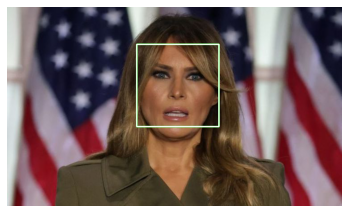

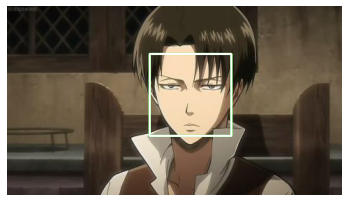

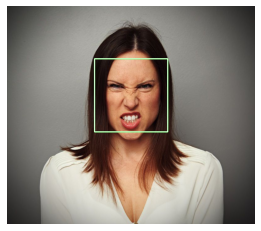

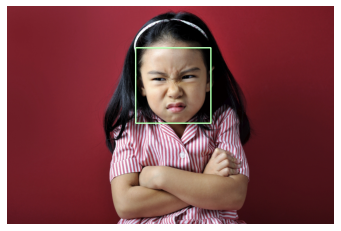

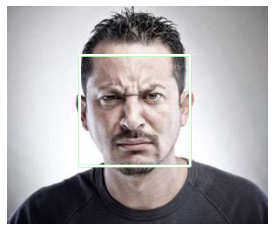

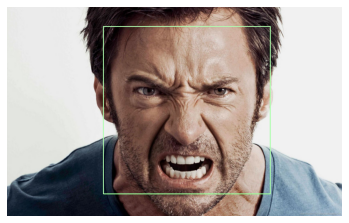

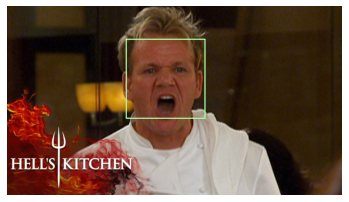

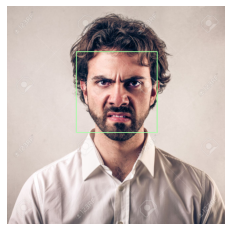

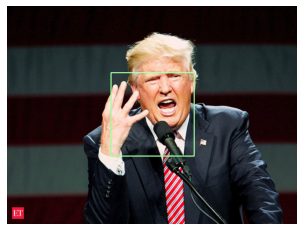

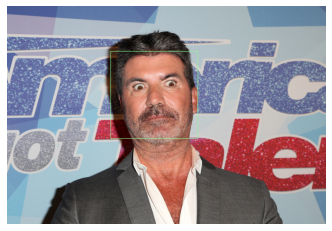

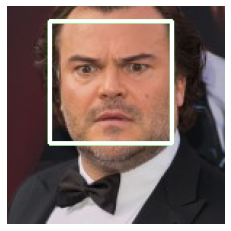

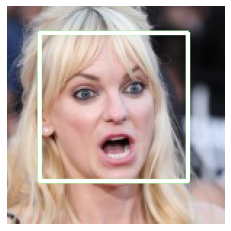

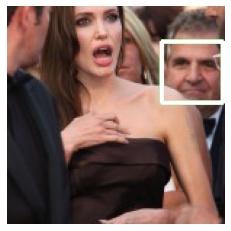

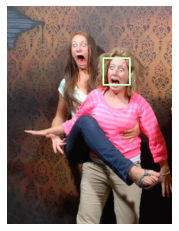

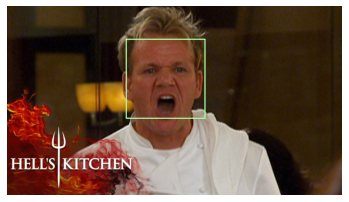

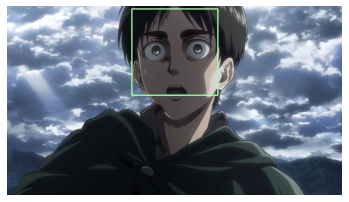

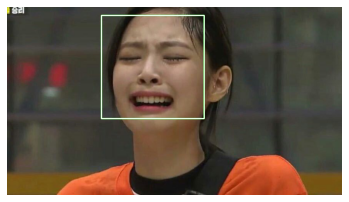

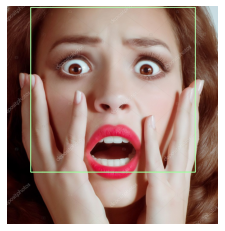

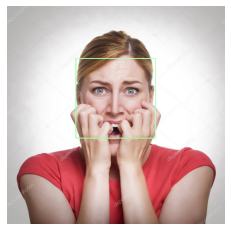

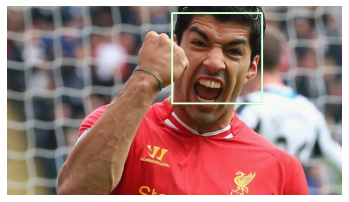

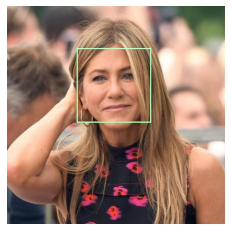

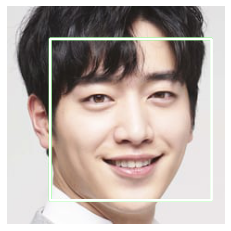

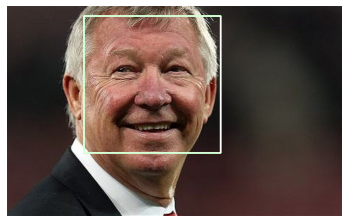

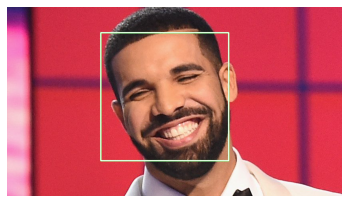

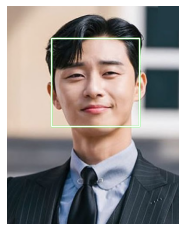

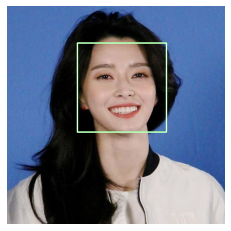

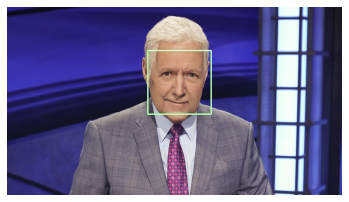

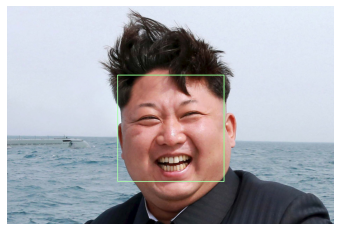

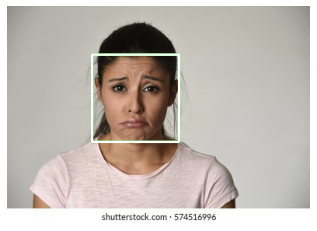

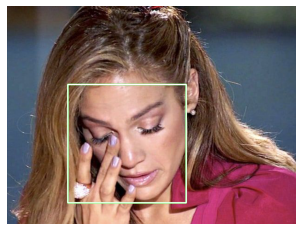

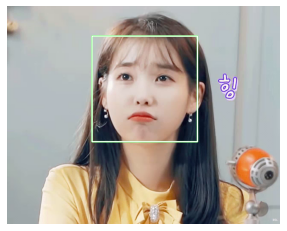

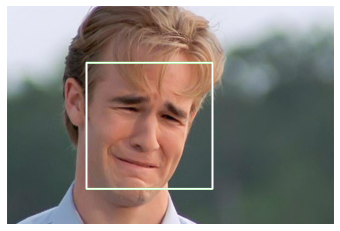

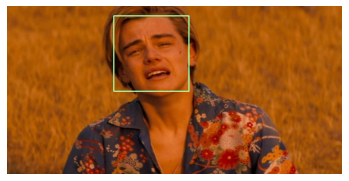

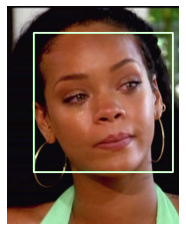

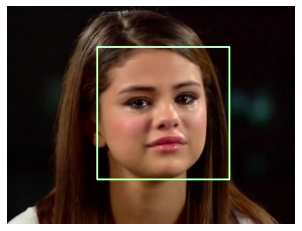

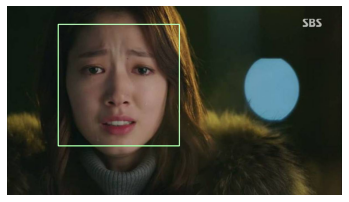

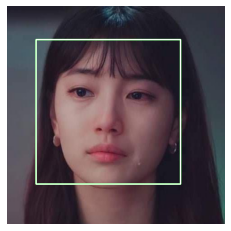

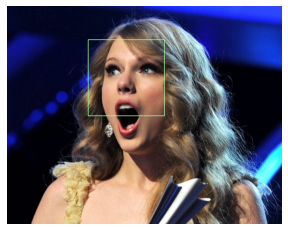

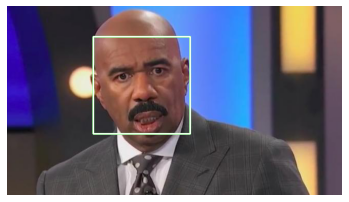

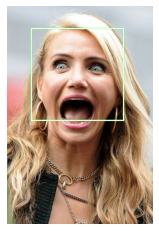

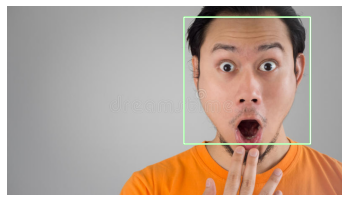

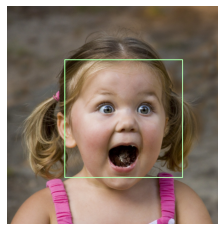

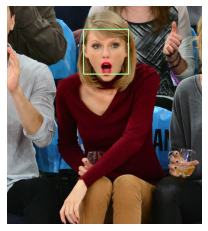

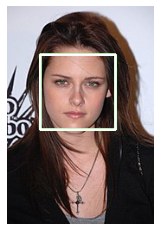

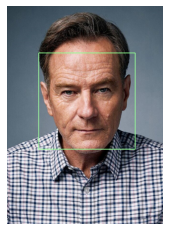

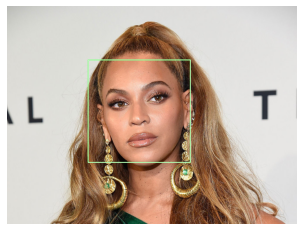

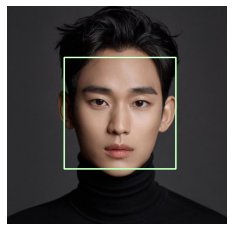

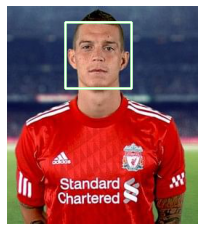

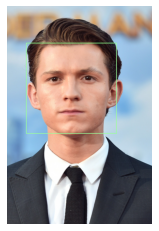

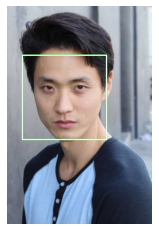

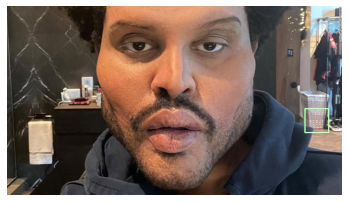

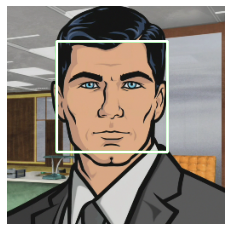

In [ ]:
#loops through all image urls in our unseen dataset and returns the marked image
for url in test['url']:
  mark_image(url)

**Function to show processed images** - This is just for us to take a look at what raw images resulted in after passing through our processing function.

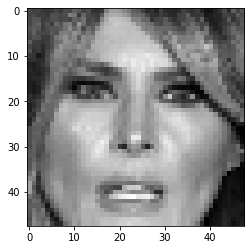

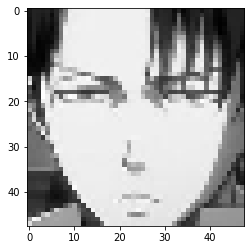

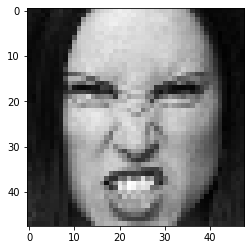

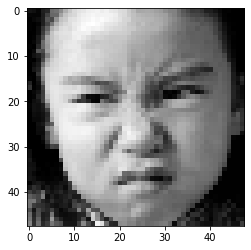

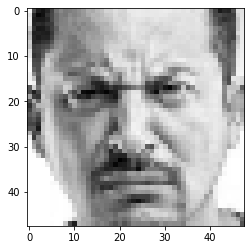

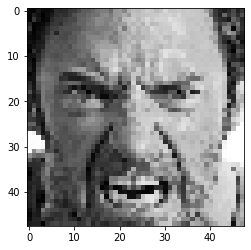

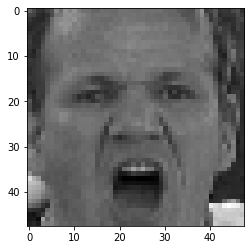

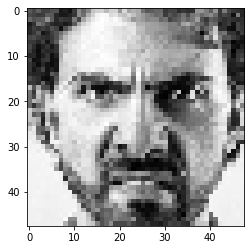

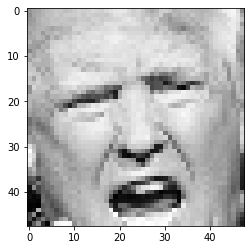

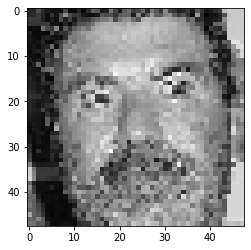

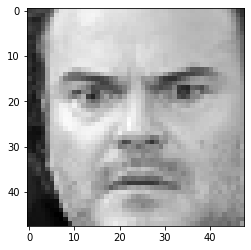

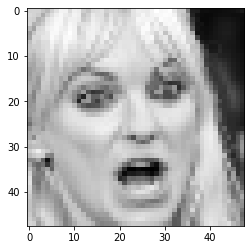

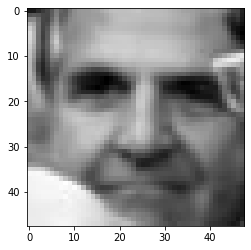

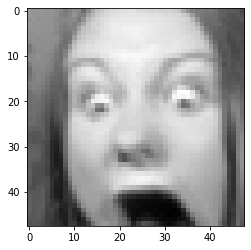

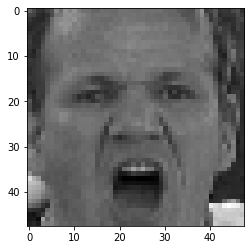

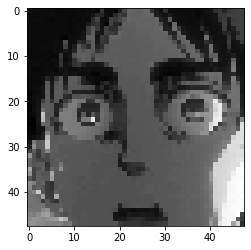

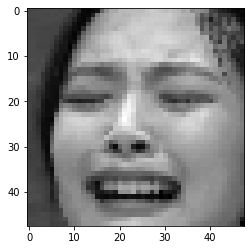

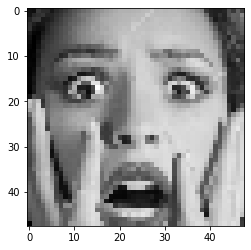

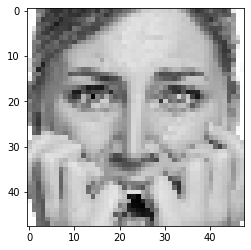

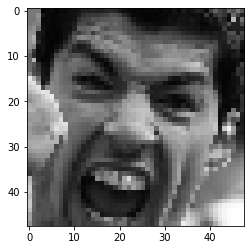

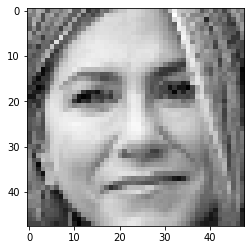

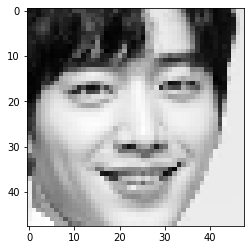

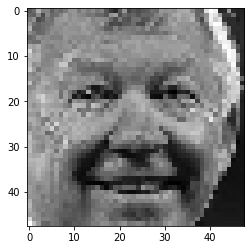

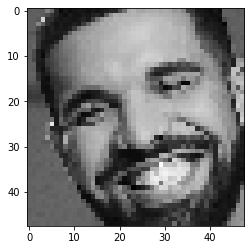

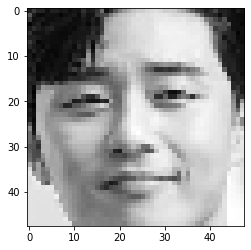

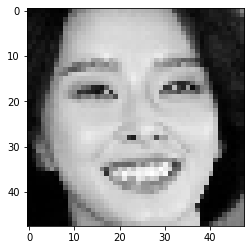

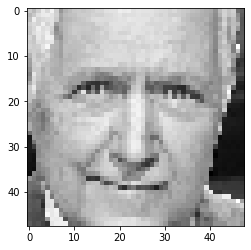

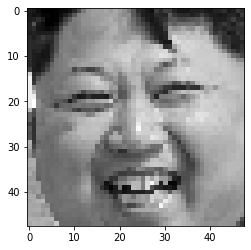

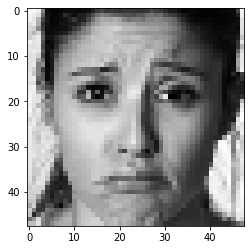

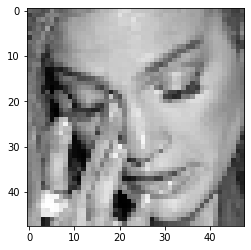

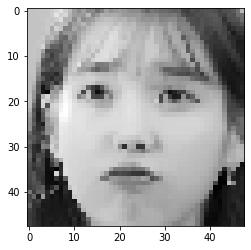

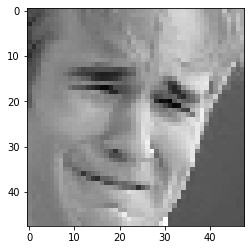

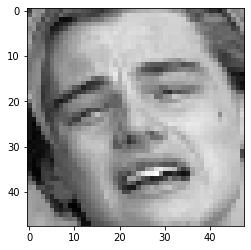

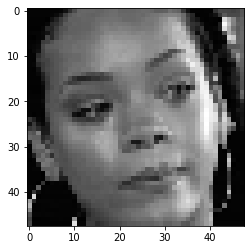

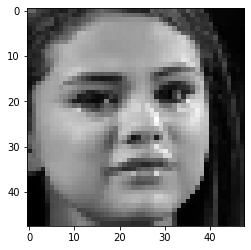

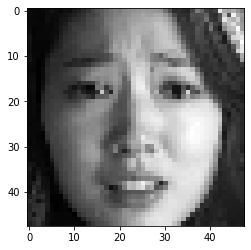

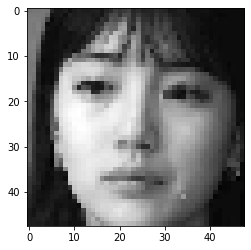

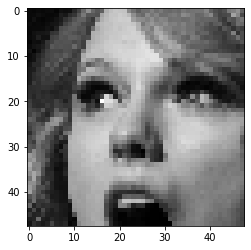

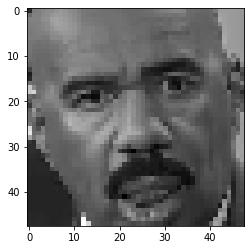

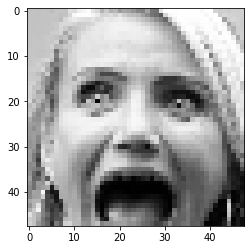

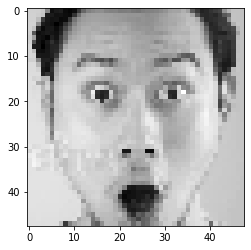

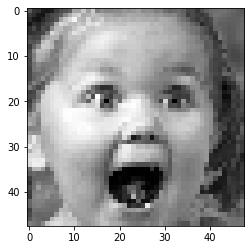

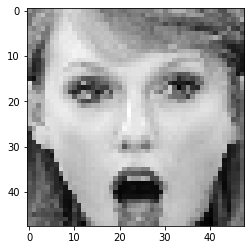

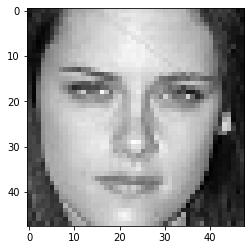

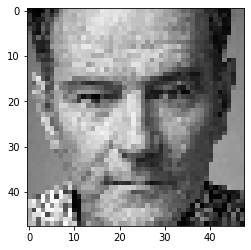

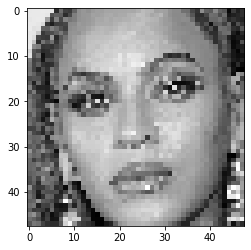

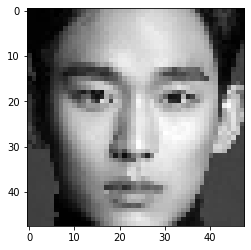

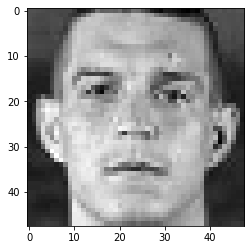

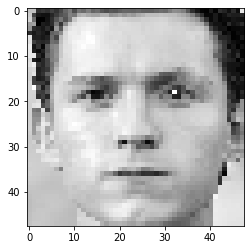

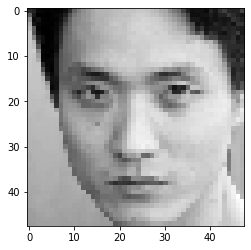

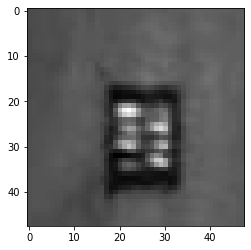

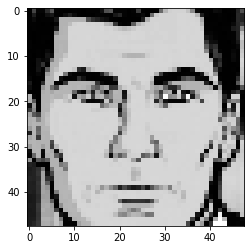

In [ ]:
#showing processed images from dataset
np.array(list(test['processed']))
def show(img):
    show_image = img.reshape(48, 48)
    plt.imshow(show_image, cmap = 'gray')
    plt.show()
for img in test['processed']:
  show(img)